In [32]:
import json
import arxiv
import requests
from pathlib import Path
import os
import re
from dotenv import load_dotenv
from copy import deepcopy
from tqdm import tqdm

from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

from openai import OpenAI
import openai
from prompt import * 

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

class CitationLinker():
    def __init__ (self, config):
        self.target_id = config['arxiv_id']
        self.preprocess_threhsold = config['preprocess_threhsold']
        self.reference_ratio = config['reference_ratio']
        self.reference_condition = config['reference_condition']
        self.model = config['model']

        self.essay_dir = Path(config['essay_dir'])
        self.result_dir = Path(config['result_dir'])
        CitationLinker.create_directory_if_not_exists(self.essay_dir)
        CitationLinker.create_directory_if_not_exists(self.result_dir)

        self.title = None
        self.authors = None
        self.submitted = None
        self.abstract = None
        self.pdf_url = None

        self.basic_keys = ["Title", "Authors", "Submitted" ,"Abstract"]
        self.references = ['References']
        
        self.content_config = config['content_keys']
        self.content_keys = [value_dict["name"] for _, value_dict in self.content_config.items()]
        
        # self.summarize_keys = list(set(self.content_keys) - set(self.references))
        # self.reference_count_keys = [key for key in self.content_keys if key not in set(self.basic_keys + self.references)]
    
    @staticmethod
    def create_directory_if_not_exists(directory_path):
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
            print(f"디렉토리 '{directory_path}'가 생성되었습니다.")
        else:
            raise FileExistsError(f"에러: '{directory_path}' 디렉토리가 이미 존재합니다.")

    def _search_arxiv_pdf(self, arxiv_id):
        search = arxiv.Search(id_list=[arxiv_id])
        for result in search.results():
            break
        print(f"📌 Title: {result.title}")
        print(f"📝 Authors: {', '.join([author.name for author in result.authors])}")
        print(f"📅 Submitted: {result.published}")
        print(f"🔗 PDF Link: {result.pdf_url}")
        print(f"📝 Abstract:\n{result.summary}")
        self.title = result.title
        self.authors = ', '.join([author.name for author in result.authors])
        self.submitted = str(result.published)
        self.abstract = result.summary
        self.pdf_url = result.pdf_url

    def _download_arxiv_pdf(self, pdf_url, save_path):
        response = requests.get(pdf_url, stream=True)
        if response.status_code == 200:
            with open(save_path, "wb") as file:
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)
        print("논문 저장 완료!")

    def _fetch_arxiv_paper(self, title, max_results=30):
        
        search = arxiv.Search(
            query=title,
            max_results=max_results, 
            sort_by=arxiv.SortCriterion.Relevance
        )

        for result in search.results():
            if title[10:-10].lower().replace(" ", "") in result.title.lower().replace(" ", ""):
                return ( {
                    "title": result.title,
                    "abstract": result.summary,
                    "pdf_url": result.pdf_url
                })
            
        return None 

    def _preprocess(self, save_path):
        # 데이터를 불러와 섹션 별로 나눕니다.
        loader = UnstructuredPDFLoader(save_path)
        documents = loader.load()
        processed_output = {}
        for key, value_dict in self.content_config.items():
            if value_dict['name'] == "Title":
                processed_output[value_dict['name']]=self.title
            elif value_dict['name'] == "Authors":
                processed_output[value_dict['name']]=self.authors
            elif value_dict['name'] == "Submitted":
                processed_output[value_dict['name']]=self.submitted
            elif value_dict['name'] == "Abstract":    
                processed_output[value_dict['name']]=self.abstract
            else:
                processed_output[value_dict['name']]=documents[0].page_content.split(value_dict['deliminators']['forward'])[-1].split(value_dict['deliminators']['backward'])[0]

        # basic_key가 아닌 섹션 중 threshold 미만으로 잘리면 모두 없앱니다.
        threshold = self.preprocess_threhsold
        for key in self.content_keys:
            if key not in self.basic_keys:
                result = []
                for text in processed_output[key].split("\n"):
                    if len(text) >= threshold:
                        result.append(text)
                processed_output[key] = "\n".join(result)
        
        # 2000자 단위로 모두 자릅니다.
        text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=2000, 
                chunk_overlap=0  
            )
        
        for key in self.content_keys:
            documents = text_splitter.create_documents([processed_output[key]])
            for doc in documents:
                doc.metadata = {"Title": self.title, "Key": key} 
            processed_output[key] = documents

        return processed_output
    
    @staticmethod
    def _message_to_openai(message, model):
        response = client.chat.completions.create(
            model=model,
            store=True,
            messages=[{"role": "user", "content": message}],
            temperature=0
        )
        return response

    def forward(self):

        # 논문 id를 받아서 논문을 다운 받습니다.
        self._search_arxiv_pdf(arxiv_id=self.target_id)
        title = self.title
        save_path = self.essay_dir / f"0-{title[:15]}.pdf"
        self._download_arxiv_pdf(
            pdf_url=self.pdf_url, 
            save_path=save_path
        )

        # 텍스트 전처리
        processed_output = self._preprocess(
            save_path=save_path
        )

        # 기본 요약
        essay = ""
        for key in self.content_keys:
            if key not in self.references:
                for doc in processed_output[key]:
                    essay += doc.page_content + "\n\n"
        basic_summarize_message = basic_summarize_template.format(essay=essay)
        response = CitationLinker._message_to_openai(message=basic_summarize_message, model=self.model)
        with open(self.result_dir/"basic_summary.json", 'w', encoding="utf-8") as f:
            json.dump(response.choices[0].message.content, f, ensure_ascii=False, indent=4)

        # 참고문헌 목록화
        reference_extraction_message = reference_extraction_template.format(references=processed_output['References'])
        flag = True
        while flag:
            response = CitationLinker._message_to_openai(message=reference_extraction_message, model=self.model)
            text = response.choices[0].message.content
            text = re.sub("```json","",text)
            text = re.sub("```","",text)
            json_data = json.loads(text)
            flag = False
            
        reference_dict = {}
        for key, dict_data in json_data.items():
            dict_data['Counter'] = 0
            dict_data['Context'] = []
            reference_dict[key] = dict_data
        processed_output['References'] = deepcopy(reference_dict)

        # 인용횟수 counting
        for index in range(len(reference_count_template_dict)):
            result = []
            for key in self.content_keys:
                if key not in self.basic_keys + self.references:
                    for essay in processed_output[key]:
                        reference_count_message = reference_count_template_dict[str(index)].format(references=reference_dict, essay=essay, condition=self.reference_condition)
                        response = CitationLinker._message_to_openai(reference_count_message, model=self.model)
                        try:
                            text = response.choices[0].message.content
                            text = re.sub("```json","",text)
                            text = re.sub("```","",text)
                            text_data = json.loads(text)
                            result.append(text_data)
                        except: 
                            text_data = None
                        # items['References'] = text_data

            for data in result:
                for key, value_dict in data.items():
                    processed_output["References"][key]['Counter'] += value_dict['Counter']
                    processed_output["References"][key]['Context'].extend(value_dict['Context'])

        # reference 논문 다운 받아오기
        for index in range(len(processed_output['References'])):
            title = processed_output['References'][str(index+1)]['Title']
            try :
                paper_info = self._fetch_arxiv_paper(title)
                if paper_info is None:
                    paper_info = self._fetch_arxiv_paper(title, 150)
            except Exception as e:
                print(index+1,"번째 논문 예외 발생: ", e)
                try :
                    paper_info = self._fetch_arxiv_paper(title, None)
                except:
                    paper_info = None

            if paper_info is not None:
                pdf_url = paper_info['pdf_url']
                abstract = paper_info['abstract']
                processed_output['References'][str(index+1)]['abstract'] = abstract
                processed_output['References'][str(index+1)]['pdf_url'] = pdf_url
                save_path = self.essay_dir / (str(index+1)+ "-" + paper_info['title'][:15]+".pdf")
                self._download_arxiv_pdf(pdf_url, save_path)
                print(index+1,"번째 논문 다운로드 완료")
            
            else:
                pdf_url = None
                abstract = None
                processed_output['References'][str(index+1)]['abstract'] = abstract
                processed_output['References'][str(index+1)]['pdf_url'] = pdf_url
                print(index+1,"번째 논문 다운로드 실패")
                print(f"    {processed_output['References'][str(index+1)]['Title']}")

        # 논문 다운로드 후, 질문 축소
        filtered_reference_dict = { key: value for key, value in processed_output['References'].items() if value['pdf_url'] is not None}
        nums = int(round(len(processed_output['References'])*self.reference_ratio, 0))
        related_reference = dict(sorted(filtered_reference_dict.items(), key=lambda x:x[1]['Counter'], reverse=True)[:nums])
        total_related_reference = dict(sorted(filtered_reference_dict.items(), key=lambda x:x[1]['Counter'], reverse=True))
        # print(total_related_reference)
        # result['total_reference_result_dict'] = total_related_reference
        with open(self.result_dir/"reference_count.json", 'w', encoding="utf-8") as f:
            json.dump(total_related_reference, f, ensure_ascii=False, indent=4)

        for index in related_reference.keys():
            query_list = related_reference[index]['Context']
            user_message = question_reduction_template.format(text_list=query_list)
            response = CitationLinker._message_to_openai(user_message, model=self.model)
            related_reference[index]['Questions'] = response.choices[0].message.content

        # reference와의 접점을 찾기 위한 요약
        main_essay = ""
        for key in self.basic_keys:
            for doc in processed_output[key]:
                main_essay += (doc.page_content + "\n\n")

        for index in tqdm(related_reference.keys(), desc="인용 논문과의 관련 지점 정리..."):
            title = related_reference[index]['Title']
            questions = related_reference[index]['Questions']
        
            for path in self.essay_dir.rglob("*.pdf"):
                if path.name.split("-")[0] == index:
                    break
        
            loader = UnstructuredPDFLoader(path)
            documents = loader.load()
            essay = documents[0].page_content
            essay = "\n".join([text for text in essay.split("\n") if len(text) >= self.preprocess_threhsold])
            reference_qna_message = reference_qna_template.format(essay = essay, questions=questions, title=title)
            response = CitationLinker._message_to_openai(reference_qna_message, model=self.model)
            summary = response.choices[0].message.content
            related_reference[index]['Summary'] = summary
            
            research_progress_message = research_progress_template.format(title=processed_output['Title'], essay=main_essay, qna = summary)
            response = CitationLinker._message_to_openai(research_progress_message,model=self.model)
            summary_qna = response.choices[0].message.content
            related_reference[index]['Summary_QnA'] = summary_qna

        with open(self.result_dir/"reference_qna.json", 'w', encoding="utf-8") as f:
            json.dump(related_reference, f, ensure_ascii=False, indent=4)

if __name__ == "__main__":

    with open("config.json",'r') as f:
        config = json.load(f)

    citation_linker = CitationLinker(config)
    citation_linker.forward()

디렉토리 'reference'가 생성되었습니다.
디렉토리 'result'가 생성되었습니다.


/tmp/ipykernel_107714/2208113697.py:61: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


📌 Title: How Do Large Language Models Acquire Factual Knowledge During Pretraining?
📝 Authors: Hoyeon Chang, Jinho Park, Seonghyeon Ye, Sohee Yang, Youngkyung Seo, Du-Seong Chang, Minjoon Seo
📅 Submitted: 2024-06-17 17:54:40+00:00
🔗 PDF Link: http://arxiv.org/pdf/2406.11813v3
📝 Abstract:
Despite the recent observation that large language models (LLMs) can store
substantial factual knowledge, there is a limited understanding of the
mechanisms of how they acquire factual knowledge through pretraining. This work
addresses this gap by studying how LLMs acquire factual knowledge during
pretraining. The findings reveal several important insights into the dynamics
of factual knowledge acquisition during pretraining. First, counterintuitively,
we observe that pretraining on more data shows no significant improvement in
the model's capability to acquire and maintain factual knowledge. Next, there
is a power-law relationship between training steps and forgetting of
memorization and generalizatio

/tmp/ipykernel_107714/2208113697.py:90: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


논문 저장 완료!
1 번째 논문 다운로드 완료
논문 저장 완료!
2 번째 논문 다운로드 완료
논문 저장 완료!
3 번째 논문 다운로드 완료
논문 저장 완료!
4 번째 논문 다운로드 완료
논문 저장 완료!
5 번째 논문 다운로드 완료
논문 저장 완료!
6 번째 논문 다운로드 완료
논문 저장 완료!
7 번째 논문 다운로드 완료
논문 저장 완료!
8 번째 논문 다운로드 완료
논문 저장 완료!
9 번째 논문 다운로드 완료
논문 저장 완료!
10 번째 논문 다운로드 완료
논문 저장 완료!
11 번째 논문 다운로드 완료
논문 저장 완료!
12 번째 논문 다운로드 완료
논문 저장 완료!
13 번째 논문 다운로드 완료
논문 저장 완료!
14 번째 논문 다운로드 완료
논문 저장 완료!
15 번째 논문 다운로드 완료
16 번째 논문 다운로드 실패
    Measuring causal effects of data statistics on language model’s ’factual’ predictions
논문 저장 완료!
17 번째 논문 다운로드 완료
논문 저장 완료!
18 번째 논문 다운로드 완료
논문 저장 완료!
19 번째 논문 다운로드 완료
논문 저장 완료!
20 번째 논문 다운로드 완료
21 번째 논문 다운로드 실패
    Olmo: Accelerating the science of language models
22 번째 논문 다운로드 실패
    Investigating learning dynamics of bert fine-tuning
23 번째 논문 다운로드 실패
    Training compute-optimal large language models
논문 저장 완료!
24 번째 논문 다운로드 완료
논문 저장 완료!
25 번째 논문 다운로드 완료
논문 저장 완료!
26 번째 논문 다운로드 완료
논문 저장 완료!
27 번째 논문 다운로드 완료
논문 저장 완료!
28 번째 논문 다운로드 완료
논문 저장 완료!
29 번째 논문 다운로드 완료
30 번째 논문 다운로드 실

인용 논문과의 관련 지점 정리...: 100%|██████████| 11/11 [08:20<00:00, 45.48s/it]


In [33]:
import json
with open("result/basic_summary.json", 'r') as f:
    basic_summary = json.load(f)

print(basic_summary)

### 1. 기본 정보
1) 제목: How Do Large Language Models Acquire Factual Knowledge During Pretraining?
2) 저자: Hoyeon Chang, Jinho Park, Seonghyeon Ye, Sohee Yang, Youngkyung Seo, Du-Seong Chang, Minjoon Seo

### 2. 연구 목적
1) 문제의식: 대형 언어 모델의 사실적 지식 습득 메커니즘
2) 설명: 최근 대형 언어 모델(LLM)이 상당한 사실적 지식을 저장할 수 있다는 관찰이 있었으나, 이들이 사전 훈련 중 사실적 지식을 어떻게 습득하는지에 대한 이해는 부족하다. 본 연구는 LLM의 사실적 지식 습득 과정을 분석하여, 데이터 양 증가가 지식 습득에 미치는 영향, 훈련 조건에 따른 효과성, 그리고 습득한 지식의 망각 메커니즘을 탐구한다. 이를 통해 LLM의 훈련 동역학을 이해하고, 향후 연구 및 활용에 기여하고자 한다.

### 3. 연구 방법
1) 실험 방법: 연구진은 LLM의 중간 사전 훈련 체크포인트를 사용하여, 새로운 사실적 지식을 주입하고, 다양한 훈련 조건에서 지식 습득의 진행 상황을 모니터링하였다. 
2) 데이터: FICTIONAL KNOWLEDGE 데이터셋을 구성하여, 허구적이지만 현실적인 엔티티에 대한 설명을 포함한 문장을 주입하였다. 이 데이터셋은 GPT-4를 통해 생성되었다.
3) 모델 및 분석 방법: OLMo 모델을 사용하여, 주입된 지식에 대한 로그 확률을 평가하고, 메모리화, 의미적 일반화, 구성적 일반화의 세 가지 깊이에서 지식 습득을 분석하였다. 또한, 효과성 및 유지 가능성을 측정하기 위한 지표를 정의하였다.

### 4. 주요 결과
1) 연구의 주요 발견: LLM은 사실적 지식을 습득할 때, 미세한 확률 증가를 누적하는 방식으로 작동하며, 훈련 단계가 진행됨에 따라 지식 습득의 효과성은 크게 개선되지 않는다는 것을 발견하였다. 또한, 훈련 단계와 망각 간의 파워-로우 관계가 존재

In [37]:
import json
with open("result/reference_qna.json", 'r') as f:
    reference_qna = json.load(f)

for key, value_dict in reference_qna.items():
    print(value_dict['Summary'])
    print()
    print(value_dict['Summary_QnA'])
    print("##########")
    print()

인용 논문 제목 (Title): Scaling laws for neural language models

1. **질문 :** [27]은 LLM의 성능이 모델 크기와 사전 훈련 코퍼스의 크기와 긍정적으로 상관관계가 있는 스케일링 법칙을 따름을 보고하였다.
   - **답변 :** LLM의 성능은 모델 크기와 데이터셋 크기에 따라 증가하며, 이는 스케일링 법칙에 의해 설명된다. 즉, 모델의 크기와 훈련 데이터의 양이 증가할수록 성능이 향상된다는 것을 의미한다.
   - **근거 :** "Performance has a power-law relationship with each of the three scale factors N, D, C when not bottlenecked by the other two."

2. **질문 :** 다음으로, 모델이 i번째로 지식을 제공받은 후 사실적 지식의 로그 확률에서 즉각적인 개선을 정량화하기 위한 메트릭을 정의한다.
   - **답변 :** 모델이 특정 지식을 제공받은 후의 로그 확률 개선을 측정하기 위해 메트릭을 정의하는 것은 모델의 학습 효과를 평가하는 데 중요하다.
   - **근거 :** "We define a metric to quantify the immediate improvement in the model’s log probability of factual knowledge after it is presented with the knowledge for the i-th time."

3. **질문 :** 정의된 메트릭의 측정은 그림 1에 설명되어 있다. 효과성과 유지 가능성의 측정을 위해 IQR 방법을 사용하여 이상치 탐지를 적용한다.
   - **답변 :** 효과성과 유지 가능성을 측정하기 위해 IQR 방법을 사용하여 이상치를 탐지하는 것은 데이터의 신뢰성을 높이는 데 기여한다.
   - **근거 :** "For the measurement of effectivity and retainability, we

/tmp/ipykernel_107714/2094099114.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="title", y="citation_score", data=df, palette="coolwarm")


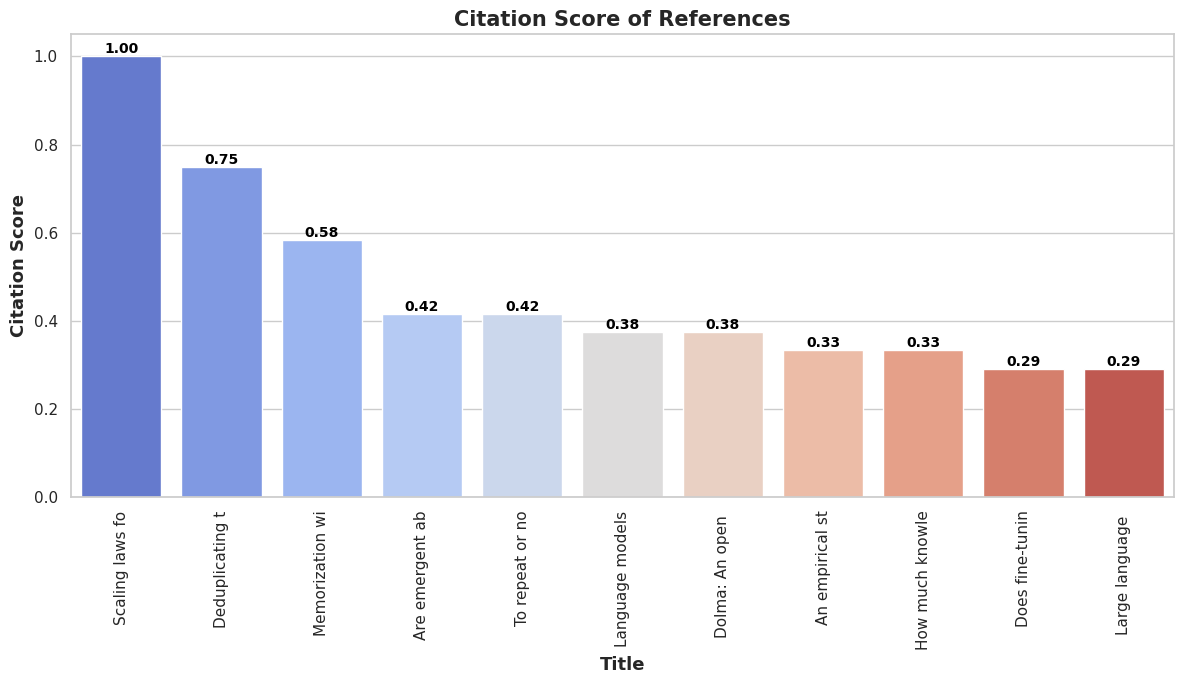

In [53]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# JSON 파일 로드
with open("result/reference_count.json", 'r') as f:
    reference_count = json.load(f)

# 최대 citation count 구하기
for key, value_dict in reference_count.items():
    max_count = int(value_dict['Counter'])
    break

# Citation Score 계산
nums = 11
score_dict = {}
for key, value_dict in reference_count.items():
    score_dict[value_dict['Title'][:15]] = int(value_dict['Counter']) / max_count

df = pd.DataFrame(list(score_dict.items())[:nums], columns=["title", "citation_score"])

# 🌟 Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 🎨 Seaborn 막대 그래프 그리기 (색상 변경)
plt.figure(figsize=(12, 7))
ax = sns.barplot(x="title", y="citation_score", data=df, palette="coolwarm")

# X축 라벨 90도 회전 & 폰트 크기 조정
plt.xticks(rotation=90, fontsize=11)
plt.yticks(fontsize=11)

# 라벨 추가
plt.xlabel("Title", fontsize=13, fontweight='bold')
plt.ylabel("Citation Score", fontsize=13, fontweight='bold')
plt.title("Citation Score of References", fontsize=15, fontweight='bold')

# 막대 위에 값 표시 (숫자)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight="bold", color="black")

# 여백 조정
plt.tight_layout()

# 그래프 출력
plt.show()


In [47]:

df

,tile,citation_score
0,Scaling laws for neural language models,1.000000
1,Deduplicating training data makes language mod...,0.750000
2,Memorization without overfitting: Analyzing th...,0.583333
3,Are emergent abilities of large language model...,0.416667
4,To repeat or not to repeat: Insights from scal...,0.416667
5,Language models are few-shot learners,0.375000
6,Language models as knowledge bases?,0.375000
7,Dolma: An open corpus of three trillion tokens...,0.375000
8,An empirical study of catastrophic forgetting ...,0.333333
9,How much knowledge can you pack into the param...,0.333333


In [42]:
title_lst

['Scaling laws for neural language models',
 'Deduplicating training data makes language models better',
 'Memorization without overfitting: Analyzing the training dynamics of large language models',
 'Are emergent abilities of large language models a mirage?',
 'To repeat or not to repeat: Insights from scaling llm under token-crisis',
 'Language models are few-shot learners',
 'Language models as knowledge bases?',
 'Dolma: An open corpus of three trillion tokens for language model pretraining research',
 'An empirical study of catastrophic forgetting in large language models during continual fine-tuning',
 'How much knowledge can you pack into the parameters of a language model?',
 'Does fine-tuning llms on new knowledge encourage hallucinations?',
 'Large language models struggle to learn long-tail knowledge',
 'Physics of language models: Part 3.2, knowledge manipulation',
 'Llama 2: Open foundation and fine-tuned chat models',
 'Gpt-4 technical report',
 'Physics of language mode

In [41]:
importance_list

[1.0,
 0.75,
 0.5833333333333334,
 0.4166666666666667,
 0.4166666666666667,
 0.375,
 0.375,
 0.375,
 0.3333333333333333,
 0.3333333333333333,
 0.2916666666666667,
 0.2916666666666667,
 0.25,
 0.25,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.125,
 0.125,
 0.125,
 0.08333333333333333,
 0.041666666666666664,
 0.041666666666666664,
 0.041666666666666664,
 0.041666666666666664,
 0.041666666666666664,
 0.041666666666666664,
 0.0,
 0.0,
 0.0]